## Estilização da Saída do Markdown

In [107]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>


# Simulador de um Conversor Buck com CPL (Carga de Potência Constante)

## Descrição

Este notebook apresenta a implementação da modelagem matemática e do controlador de uma microrrede de corrente contínua, representada por um conversor buck com uma CPL (Carga de Potência Constante). O conversor buck é um dispositivo de conversão de potência que transforma uma tensão contínua de alta para baixa. A CPL é uma carga que demanda potência constante, independentemente da variação na tensão de entrada.

Para a implementação, serão utilizadas as bibliotecas Python Control, NumPy e Matplotlib. A modelagem matemática detalhada pode ser encontrada no documento separado chamado ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), localizado no diretório `docs`. Durante a implementação, serão explorados o sistema não linear, o sistema não linear transladado e o sistema linearizado, todos derivados da modelagem matemática.

### Data de Criação

2023-12-21

### Data de Modificação

2024-04-20

## Autor

Andevaldo da Encarnação Vitório  ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br))

## Orientador

Iury Valente de Bessa ([iury@ufam.edu.br](mailto:iury@ufam.edu.br))


## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

O código apresentado no início do tópico realiza a importação de diversas bibliotecas que serão utilizadas ao longo do desenvolvimento. Cada biblioteca possui um papel específico e contribui para o funcionamento do código:

- [`numpy`](https://numpy.org/): Biblioteca fundamental para manipulação de arrays e matrizes em Python. É utilizada para realizar cálculos matemáticos e operações com dados numéricos.
- [`matplotlib.pyplot`](https://matplotlib.org/): Biblioteca para criação de visualizações gráficas, como gráficos e diagramas. Permite a plotagem de dados e resultados de forma interativa e customizável.
- [`control`](https://python-control.readthedocs.io/): Biblioteca específica para análise e controle de sistemas dinâmicos. Fornece ferramentas para modelagem, simulação e análise de sistemas lineares e não lineares.

`ct.use_fbs_defaults()` define configurações padrão para o módulo `control`.

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
import pandas as pd
ct.use_fbs_defaults()

In [109]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [110]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)

In [111]:
def generate_square_signal(timepts, signal_data):
  signal = np.zeros(len(timepts))
  for i, t in enumerate(timepts):
    for j in range(len(signal_data) - 1):
      if signal_data[j][0] <= t < signal_data[j + 1][0]:
        signal[i] = signal_data[j][1]
        break
    else:
      signal[i] = signal_data[-1][1]
  return signal

In [112]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [113]:
def set_axe_stem(ax, x, y, xlabel, ylabel, linefmt='-', markerfmt=None, basefmt=' ', bottom=0, grid=True, fontsize=16):
  """
  Plota os gráficos de hastes (stem plots) em um subplot e configura os eixos.

  Parâmetros:
                  ax (AxesSubplot): Eixo do subplot.
                  x (array): Valores para o eixo x.
                  y (array): Valores para o eixo y.
                  xlabel (str): Rótulo do eixo x.
                  ylabel (str): Rótulo do eixo y.
                  linefmt (str): Formato da linha. O padrão é '-'.
                  markerfmt (str): Formato do marcador. O padrão é None.
                  basefmt (str): Formato da base. O padrão é None.
                  bottom (float): Posição da base das hastes. O padrão é 0.
                  grid (bool): Se True, habilita as linhas de grade. O padrão é True.
                  fontsize (int): Tamanho da fonte. O padrão é 16.
  """
  ax.stem(x, y, linefmt=linefmt, markerfmt=markerfmt,
          basefmt=basefmt, bottom=bottom)
  ax.set_xlabel(xlabel, fontsize=fontsize)
  ax.set_ylabel(ylabel, fontsize=fontsize)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=fontsize)
  if grid:
    ax.grid(linestyle='--')

## 2. Description of the Buck Converter Circuit

The Buck converter utilized in this simulator is composed of a basic Buck converter with an RLC output voltage filter, as depicted in Figure 1. The converter supplies two loads: a Constant Resistance Load (CRL) and a Constante Power Load (CPL). 

<p align="center">
	<img src="../assets/buck-converter/circuit.svg" alt="Buck Converter" style="max-width:80%; height:260px;"/> 
	<br>
	<strong>Figure 1:</strong> Buck converter circuit.
</p>

In the presented circuit:

- $R_L$: Inductor winding resistance;
- $R_C$: Constant resistance load;
- $L$: Inductance;
- $C$: Capacitance;
- $d$: Duty cycle;
- $v_C(t)$: Capacitor voltage;
- $i_L(t)$: Indutor current;
- $\mathrm{P}_{\mathrm{cpl}}(t)$: CPL power;
- $i_{\mathrm{cpl}}(t)$: CPL current;
- $v_{in}$: Input voltage;
- $v_{out}$: Output voltage;

### 2.1 Non-shifted Nonlinear Dynamic Model

#### 2.1.1 Model definition

From Kirchhoff's current and voltage laws, the non-shifted dynamic model of the system can be established as follows:

$$\begin{cases} 
\dot{i}_L &= \displaystyle - \frac{R_L}{L} i_L(t) - \frac{1}{L} v_C(t) + \frac{v_{\mathrm{in}}}{L}d(t)  \\[8pt] 
\dot{v}_C &= \displaystyle \frac{1}{C} i_L(t) - \frac{1}{C R_C} v_C(t) - \frac{1}{C v_C(t)} P_{\mathrm{cpl}}(t) 
\end{cases}$$

where $i_L(t)$ and $v_C(t)$ are the system states, and $d(t)$ and $P_{\mathrm{cpl}}(t)$ are the inputs.

#### 2.1.2 Model implementation

Definition of an update function (for the right side of the differential equation) and an output function (calculating the outputs from the state).

In [114]:
class NonlinearBuckConverter:
  """
  Classe para criar e gerenciar o modelo não linear de um conversor Buck.

  Parâmetros:
                  name (str): Nome do sistema.
  """

  def __init__(self, name):
    self.name = name
    self.inputs = ('D', 'P_CPL')
    self.outputs = ('iL', 'vC')
    self.states = ('iL', 'vC')
    self.system = ct.NonlinearIOSystem(
        self.update, self.output, name=self.name,
        inputs=self.inputs, outputs=self.outputs, states=self.states
    )

  def update(self, t, x, u, params):
    """
    Função de atualização para a representação em espaço de estados do conversor Buck.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    dx (array): Derivada dos estados do sistema.
    """
    V_IN = params.get('Vin', 0)  # Tensão de entrada
    RL = params.get('rL', 0)     # Resistência (indutor)
    RC = params.get('rC', 0)     # Resistência (capacitor)
    L = params.get('L', 1)       # Indutância
    C = params.get('C', 1)       # Capacitância

    D, P_CPL = u

    IL, VC = x

    diL = (V_IN / L) * D - (RL / L) * IL - VC / L
    dvC = IL / C - VC / (C * RC) - P_CPL / (C * VC)

    dx = np.array([diL, dvC])
    return dx

  def output(self, t, x, u, params):
    """
    Função de saída para a representação em espaço de estados do conversor Buck.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    array: Saída do sistema.
    """
    return x[0:2]

### 2.2 Shifted Nonlinear Dynamic Model

#### 2.2.1 Operation Point

Upon delving into the shifted system model, it's important first to define the state variables and the operating values. These definitions will be used to describe the behavior of the shifted system.

Given the operating condition $P^{\mathrm{o}} = \left( i_L^{\mathrm{o}}, \space v_C^{\mathrm{o}}, \space d^{\mathrm{o}}, \space P_{\mathrm{cpl}}^{\mathrm{o}} \right) $, the system's states and inputs can be decomposed into fixed terms and time-varying terms.

$$
x(t): \space
\begin{cases}
	i_L(t) &= i_L^{\mathrm{o}} + \delta i_L(t) \\
	v_C(t) &= v_C^{\mathrm{o}} + \delta v_C(t) 
\end{cases}
, \space \space \space \space \space
u(t): \space
\begin{cases}
	d(t) &= d^{\mathrm{o}} + \delta d(t) \\
	P_{\mathrm{cpl}}(t) &= P_{\mathrm{cpl}}^{\mathrm{o}} + \delta P_{\mathrm{cpl}}(t)
\end{cases}
$$

Furthermore, the temporal derivatives of the state variables are also represented as:

$$
\dot{x}: \space
\begin{cases}
	\dot{i_L} &= \dot{i_L}^{\mathrm{o}}+ \delta \dot{i_L} \\
	\dot{v_C} &= \dot{v_C}^{\mathrm{o}}+ \delta \dot{v_C} 
\end{cases}
$$

To model the system dynamics, the following functions are defined:

$$
\begin{cases}
	f(i_L, \space v_C, \space d, \space P_{\mathrm{cpl}}) = \dot{i_L} = - \frac{R_L}{L} i_L - \frac{1}{L} v_C + \frac{v_{\mathrm{in}}}{L} d \\
	g(i_L, \space v_C, \space d, \space P_{\mathrm{cpl}}) = \dot{v_C} = - \frac{1}{C R_C} v_C + \frac{1}{C} i_L - \frac{1}{C v_C} P_{\mathrm{cpl}}
\end{cases}
$$

It's important to note that under steady-state operating conditions, the functions at the operating point are both zero:

$$ f(P_{\mathrm{o}}) = g(P_{\mathrm{o}}) = 0 $$

Additionally, the fixed points of the temporal derivatives of the states are also zero:

$$ \dot{i_L}^{\mathrm{o}} = \dot{v_C}^{\mathrm{o}} = 0$$

Based on this, it's possible to determine the duty cycle $d$ and the inductor current $i_L$ at the operating point using the capacitor voltage and the CPL power at that specific point.

$$ 
i_L^{\mathrm{o}} = \frac{1}{R_C} v_C^{\mathrm{o}} + \frac{1}{v_C^{\mathrm{o}}} P_{\mathrm{cpl}}^{\mathrm{o}}
\space , \hspace{1cm}
d^{\mathrm{o}} = \frac{R_L}{v_{\mathrm{in}}} i_L^{\mathrm{o}} + \frac{v_C^{\mathrm{o}}}{v_{\mathrm{in}}} 
$$

#### 2.2.2 Model definition

Therefore, the shifted system, considering the operating point $P^{\mathrm{o}} = \left( i_L^{\mathrm{o}}, \space v_C^{\mathrm{o}}, \space d^{\mathrm{o}}, \space P_{\mathrm{cpl}}^{\mathrm{o}} \right) $, is:

$$
\begin{equation}
\begin{cases}
\delta \dot{i_L} &= - \displaystyle\frac{R_L}{L} \delta i_L - \displaystyle\frac{1}{L} \delta v_C  + \displaystyle\frac{v_{\mathrm{in}}}{L} \delta d
\\[8pt]
\delta \dot{v_C} &= - \displaystyle\frac{1}{C R_C} \delta v_C  + \displaystyle\frac{1}{C}  \delta i_L + \displaystyle\frac{P_{\mathrm{cpl}}^{\mathrm{o}} \delta v_C - v_C^{\mathrm{o}} \delta P_{\mathrm{cpl}}}{{C v_C^{\mathrm{o}}} \left(v_C^{\mathrm{o}} + \delta v_C\right)} 
\end{cases}
\end{equation}
$$

#### 2.2.3 Model implementation

The following code implements the shifted non-linear model that describes the dynamics of the physical system by defining an operating point.

In [115]:
class ShiftedNonlinearBuckConverter:
  """
  Classe para criar e gerenciar o modelo não linear deslocado de um sistema.

  Parâmetros:
                  name (str): Nome do sistema.
  """

  def __init__(self, name):
    self.name = name
    self.inputs = ('δd', 'δPcpl')
    self.outputs = ('δiL', 'δvC')
    self.states = ('δiL', 'δvC')
    self.system = ct.NonlinearIOSystem(
        self.update, self.output, name=self.name,
        inputs=self.inputs, outputs=self.outputs, states=self.states
    )

  def update(self, t, x, u, params):
    """
    Função de atualização para a representação em espaço de estados do sistema não linear deslocado.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    dx (array): Derivada dos estados do sistema.
    """
    V_IN = params.get('Vin', 0)  # Tensão de entrada
    RL = params.get('rL', 0)     # Resistência (indutor)
    RC = params.get('rC', 0)     # Resistência (capacitor)
    L = params.get('L', 1)       # Indutância
    C = params.get('C', 1)       # Capacitância
    OP = params.get('op', {'Pcpl': 0, 'vC': 0})  # Ponto de operação

    # print(params)

    δD, δP_CPL = u
    δIL, δVC = x

    DELTA_IL_DOT = - (RL / L) * δIL - δVC / L + (V_IN / L) * δD
    DELTA_VC_DOT = - δVC / (C * RC) + δIL / C + \
        (OP['Pcpl'] * δVC - OP['vC'] * δP_CPL) / \
        (C * OP['vC'] * (OP['vC'] + δVC))

    dx = np.array([DELTA_IL_DOT, DELTA_VC_DOT])
    return dx

  def output(self, t, x, u, params):
    """
    Função de saída para a representação em espaço de estados do sistema não linear deslocado.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    array: Saída do sistema.
    """
    return x[:2]

### 2.3 Linearized Dynamic Model

#### 2.3.1 Model definition

A fim de obter o modelo linearizado, considera-se o mesmo ponto de operação definido para o modelo transladado $P\left(i_L^{\mathrm{o}}, v_C^{\mathrm{o}}, d^{\mathrm{o}}, P_{\mathrm{cpl}}^{\mathrm{o}} \right)$, no qual, para os valores escolhidos de $v_C^\mathrm{o}$ e $P_{cpl}^\mathrm{o}$, os demais parâmetros podem ser determinados por meio das seguintes relações:
\begin{align}
	 & \begin{aligned}
			 i_L^{\mathrm{o}} & = \frac{1}{R_C} v_C^{\mathrm{o}} + \frac{1}{v_C^{\mathrm{o}}} P_{\mathrm{cpl}}^{\mathrm{o}},
		 \end{aligned}
	 & \begin{aligned}
			 d^{\mathrm{o}} & = \frac{R_L}{v_{\mathrm{in}}} i_L^{\mathrm{o}} + \frac{v_C^{\mathrm{o}}}{v_{\mathrm{in}}}.
		 \end{aligned}
		 \notag
\end{align}
Dessa forma, o modelo linearizado em torno do ponto de operação $P$ é apresentado a seguir:
$$
	\begin{bmatrix}\delta \dot{i_L}(t) \\ \delta \dot{v_C}(t) \end{bmatrix} = \begin{bmatrix} \displaystyle -\frac{R_L}{L} & \displaystyle -\frac{1}{L}  \\[4pt]  \displaystyle \frac{1}{C} &  \displaystyle \frac{1}{C}\left(\frac{P_{\mathrm{cpl}}^{\mathrm{o}}}{{{v_{C}}^2_{\mathrm{o}}}} - \frac{1}{R_C}\right) \end{bmatrix} \begin{bmatrix}\delta i_L(t) \\ \delta v_C(t) \end{bmatrix} + \begin{bmatrix} \displaystyle { \frac{v_{\mathrm{in}}}{L}} & 0 \\ 0 & \displaystyle {-\frac{1}{Cv_C^{\mathrm{o}}}} \end{bmatrix} \begin{bmatrix}\delta d(t) \\ \delta P_\mathrm{cpl}(t) \end{bmatrix}
$$

#### 2.3.2 Model implementation

In [116]:
class LinearizedBuckConverter:
  """
  Classe para criar e gerenciar o modelo linearizado de um sistema.

  Parâmetros:
                  name (str): Nome do sistema.
                  params (dict): Dicionário de parâmetros do sistema e ponto de operação.
  """

  def __init__(self, name, params):
    self.name = name
    self.params = params
    self.system = self.create_system()

  def create_system(self):
    """
    Cria o modelo linearizado do sistema com base nos parâmetros fornecidos.

    Retorna:
                    system: Representação do sistema em espaço de estados linearizado.
    """
    OP = self.params['op']

    # Elementos da matriz de estados
    A11 = - (self.params['rL'] / self.params['L'])
    A12 = - (1. / self.params['L'])
    A21 = 1. / self.params['C']
    A22 = (1. / self.params['C']) * (OP['Pcpl'] /
                                     (OP['vC'] ** 2) - 1. / self.params['rC'])

    # Elementos da matriz de entrada
    B11 = self.params['Vin'] / self.params['L']
    B12 = 0.
    B21 = 0.
    B22 = - 1.0 / (self.params['C'] * OP['vC'])

    # Matriz de estados: iL e vC
    A = [[A11, A12], [A21, A22]]

    # Matriz de entrada: δd e δP_cpl
    B = [[B11, B12], [B21, B22]]

    # Matriz de saída: iL e vC
    C = [[1., 0], [0., 1]]

    # Matriz de alimentação direta: nula
    D = [[0., 0.], [0., 0.]]

    # Criando o sistema linearizado
    system = ct.ss2io(ct.ss(A, B, C, D), name=self.name, inputs=(
        'δd', 'δPcpl'), outputs=('δiL', 'δvC'), states=('δiL', 'δvC'))
    return system

## 3. Models Simulation

### 3.1 Configuration and Simulation Parameters

The `create_params` function allows to create a dictionary of parameters for the system models. It calculates the operating point (OP) values for the inductor current and duty cycle based on the system parameters and operating conditions provided.

In [117]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP / RC) + PCPL_OP / VC_OP
  D_OP = (RL * IL_OP) / V_IN + VC_OP / V_IN

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

The ```simulate()``` function is designed to simulate a buck converter based on the provided parameters and time settings. It takes as input a converter object, system parameters, and optional perturbation signal data, and returns the simulation results.

In [118]:
def simulate(converter, params, perturbation_signal_data=None, end_time=0.1, step=1e-5, initial_factor=[1.5, 0.13]):
  """
  Simulate the system based on the provided parameters and time settings.

  Parameters:
                  params (dict): Dictionary of system parameters obtained from create_params function.
                  end_time (float): End time of simulation.
                  step (float): Time step for simulation.
                  initial_factor (float): Factor to multiply the initial state values to obtain the initial conditions.
                  perturb_factor (float): Factor to multiply the perturbation values to obtain the perturbed conditions.

  Returns:
                  tuple: A tuple containing the following arrays:
                                  - timepts (array): Array of time points for simulation.
                                  - U (array): Array of system inputs for simulation.
                                  - X0 (array): Array of initial states for simulation.
                                  - δU (array): Array of perturbations in system inputs.
                                  - δX0 (array): Array of perturbations in initial states.
                                  - params (dict): Dictionary of system parameters.
  """

  # Ponto de operação de cada entrada e estado do sistema
  U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
  X_OP = np.array([params['op']['iL'], params['op']['vC']])

  # Instantes de tempo
  timepts = np.arange(0, end_time + step, step)

  # Entradas do Sistema
  if perturbation_signal_data == None:
    perturbation_signal_data = [(0., U_OP[1])]
  P_CPL = generate_square_signal(timepts, perturbation_signal_data)

  D = [params['op']['d'] for _ in range(len(timepts))]
  U = [D, P_CPL.tolist()]

  # Estados Iniciais do Sistema
  IL_INIT = initial_factor[0] * params['op']['iL']
  VC_INIT = initial_factor[1] * params['op']['vC']
  X0 = np.array([IL_INIT, VC_INIT])

  INPUT, INITIAL_STATE = U, X0

  if not isinstance(converter, NonlinearBuckConverter):
    INPUT = U - U_OP[:, np.newaxis]
    INITIAL_STATE = X0 - X_OP
  else:
    INPUT = U
    INITIAL_STATE = X0

  return ct.input_output_response(
      sys=converter.system, T=timepts,
      U=INPUT, X0=INITIAL_STATE, params=params,
  )

In [119]:
SCENARIO_TAG = 'S2'

scenarios = {
    # Stable operation point, constant Pcpl
    'S1': {
        'end_time': .1,
        'initial_states_factor': [1.5, 0.13],
        'params': create_params(
            V_IN=48, RL=0.1, RC=10, L=1e-3,
            C=2.2e-3, PCPL_OP=50, VC_OP=28
        ),
        'perturbation_signal_data': [
            # (time, value)
            (0., 50)
        ]
    },
    # Unstable operation point, constant Pcpl
    'S2': {
        'end_time': .1,
        'initial_states_factor': [.9, .9],
        'params': create_params(
            V_IN=48, RL=0.1, RC=20, L=1e-3,
            C=2.2e-3, PCPL_OP=250, VC_OP=28
        ), 'perturbation_signal_data': [
            # (time, value)
            (0., 250)
        ]
    },
    # Stable operation point, variable Pcpl
    'S3': {
        'end_time': 1.5,
        'initial_states_factor': [1.5, 0.13],
        'params': create_params(
            V_IN=48, RL=0.1, RC=10, L=1e-3,
            C=2.2e-3, PCPL_OP=50, VC_OP=28
        ),
        'perturbation_signal_data': [
            # (time, value)
            (.0, 0),
            (.1, 25),
            (.2, 50),
            (.3, 75),
            (.4, 50),
            (.5, 65),
            (.6, 30),
            (.7, 90),
            (.8, 75),
            (.9, 100),
            (1., 70),
            (1.1, 40),
            (1.2, 60),
            (1.3, 45),
            (1.4, 50),
        ]
    },
    # Unstable operation point, variable Pcpl
    'S4': {
        'end_time': 1.,
        'initial_states_factor': [.9, .9],
        'params': create_params(
            V_IN=48, RL=0.1, RC=20, L=1e-3,
            C=2.2e-3, PCPL_OP=250, VC_OP=28
        ), 'perturbation_signal_data': [
            # (time, value)
            (.0, 200),
            (.1, 150),
            (.2, 175),
            (.3, 200),
            (.4, 250),
            (.5, 125),
            (.6, 150),
            (.7, 175),
            (.8, 225),
            (.9, 250),
        ]}
}

# Show the parameters in table
circuit_parameters = pd.DataFrame({
    'Parameter': list(scenarios[SCENARIO_TAG]['params'].keys())[:-1],
    'Value': list(scenarios[SCENARIO_TAG]['params'].values())[:-1]
})

op_adjusted = {k+'_o': v for k,
               v in scenarios[SCENARIO_TAG]['params']['op'].items()}
operation_point = pd.DataFrame.from_dict(
    op_adjusted, orient='index', columns=['Value']).reset_index()
operation_point = operation_point.rename(columns={'index': 'Parameter'})
table = pd.concat([circuit_parameters, operation_point], axis=0)
table = table.reset_index(drop=True)

table['Description'] = [
    'Input voltage',
    'Inductor winding resistance',
    'Constant resistance load',
    'Inductance',
    'Capacitance',
    'CPL power (op)',
    'Capacitor voltage (op)',
    'Inductor Current (op)',
    'Duty cycle (op)'
]

colunas = list(table.columns)
colunas = ['Description'] + \
    [coluna for coluna in colunas if coluna != 'Description']
table = table[colunas]

table['Value'] = table['Value'].apply(
    lambda x: '{:.2e}'.format(x))

table = table.style.set_properties(subset=['Parameter'], **{'text-align': 'left'}) \
    .set_properties(subset=['Value', 'Description'], **{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

print('The parameters are presented below:')
display(table)

The parameters are presented below:


,Description,Parameter,Value
0,Input voltage,Vin,4.80e+01
1,Inductor winding resistance,rL,1.00e-01
2,Constant resistance load,rC,2.00e+01
3,Inductance,L,1.00e-03
4,Capacitance,C,2.20e-03
5,CPL power (op),Pcpl_o,2.50e+02
6,Capacitor voltage (op),vC_o,2.80e+01
7,Inductor Current (op),iL_o,1.03e+01
8,Duty cycle (op),d_o,6.05e-01


### 3.2 Non-linear System Simulation

In [120]:
buck_nonlinear = NonlinearBuckConverter('buck_nonlinear')

t_nonlinear, y_nonlinear = simulate(
    converter=buck_nonlinear,
    params=scenarios[SCENARIO_TAG]['params'],
    end_time=scenarios[SCENARIO_TAG]['end_time'],
    initial_factor=scenarios[SCENARIO_TAG]['initial_states_factor'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],
    step=1e-5,
)

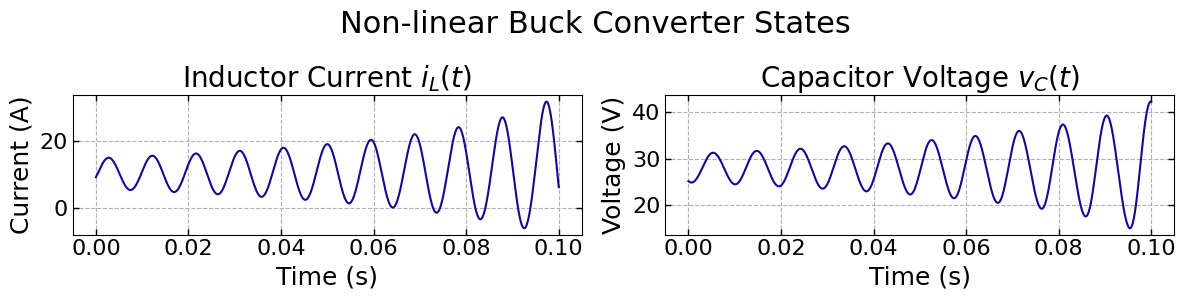

In [121]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Adicionando o título à figura
fig.suptitle("Non-linear Buck Converter States", fontsize=22)

# Configurando o subplot da Corrente do Indutor
set_subplot(
    axs[0], t_nonlinear, y_nonlinear[0],
    'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t_nonlinear, y_nonlinear[1],
    'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',
)

plt.tight_layout()

# plt.savefig(
#     '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

### 3.3 Shifted Non-linear System Simulation

In [122]:
shifted_nonlinear_sys = ShiftedNonlinearBuckConverter('buck_shifted_nonlinear')

t_shifted_nonlinear, y_shifted_nonlinear = simulate(
    converter=shifted_nonlinear_sys,
    params=scenarios[SCENARIO_TAG]['params'],
    initial_factor=scenarios[SCENARIO_TAG]['initial_states_factor'],
    end_time=scenarios[SCENARIO_TAG]['end_time'], perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],
    step=1e-5,
)

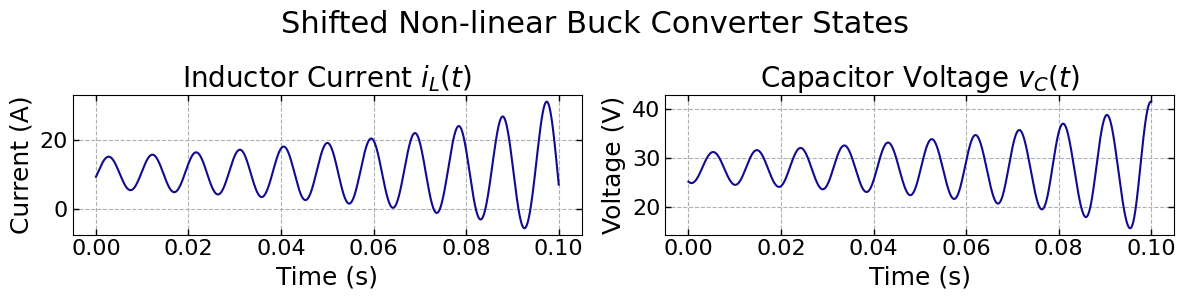

In [123]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Adicionando o título à figura
fig.suptitle("Shifted Non-linear Buck Converter States", fontsize=22)

params = scenarios[SCENARIO_TAG]['params']

# Configurando o subplot da Corrente do Indutor
set_subplot(
    axs[0], t_shifted_nonlinear, y_shifted_nonlinear[0] +
    params['op']['iL'],
    'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1], t_shifted_nonlinear, y_shifted_nonlinear[1] +
    params['op']['vC'],
    'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',
)

plt.tight_layout()

# plt.savefig(
#     '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

### 3.4 Linearized Buck Converter

In [124]:
linearized_buck_converter = LinearizedBuckConverter(
    'buck_linearized', scenarios[SCENARIO_TAG]['params'])

t_linearized, y_linearized = simulate(
    converter=linearized_buck_converter,
    params=scenarios[SCENARIO_TAG]['params'],
    end_time=scenarios[SCENARIO_TAG]['end_time'],
    initial_factor=scenarios[SCENARIO_TAG]['initial_states_factor'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],
    step=1e-5,
)

/home/andel/.local/lib/python3.10/site-packages/control/iosys.py:694: UserWarning: Parameters passed to LinearIOSystems are ignored.
  warn("Parameters passed to LinearIOSystems are ignored.")


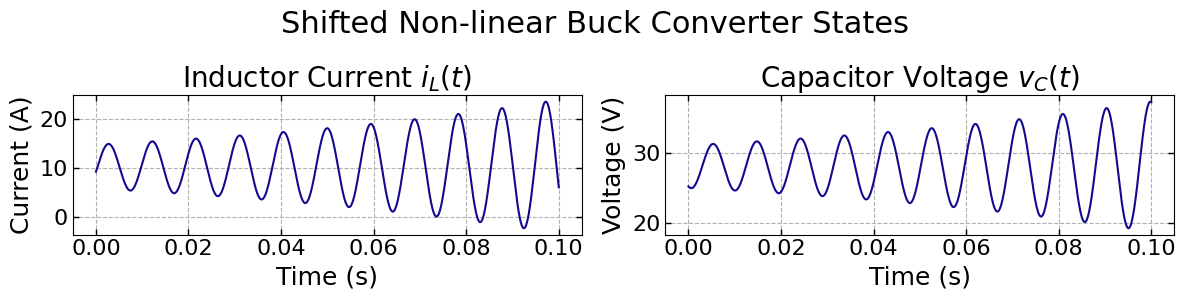

In [125]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

params = scenarios[SCENARIO_TAG]['params']

# Adicionando o título à figura
fig.suptitle("Shifted Non-linear Buck Converter States", fontsize=22)

# Configurando o subplot da Corrente do Indutor
set_subplot(
    axs[0],
    t_linearized, y_linearized[0] + params['op']['iL'],
    'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],
    t_linearized, y_linearized[1] + params['op']['vC'],
    'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',
)

plt.tight_layout()

# plt.savefig(
#     '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

### 3.5 Linearized versus Non-Linear Buck Converter Result

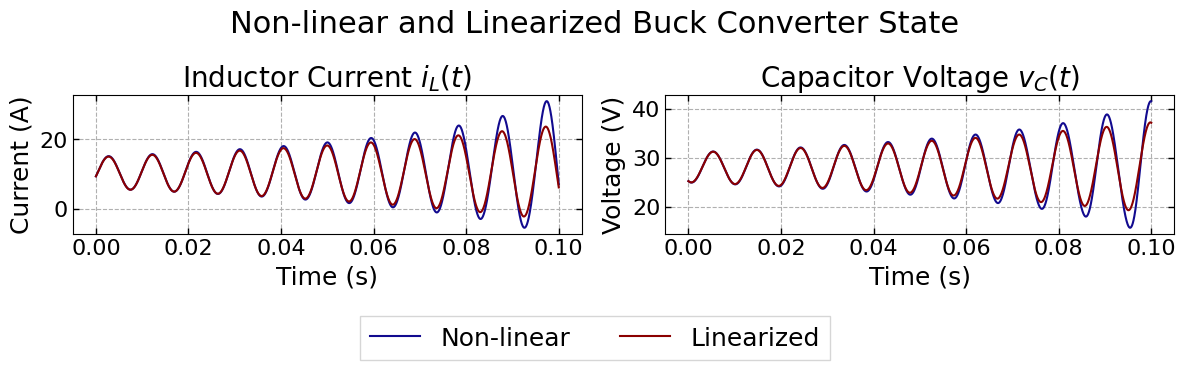

In [126]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

fig.suptitle("Non-linear and Linearized Buck Converter State", fontsize=22)
params = scenarios[SCENARIO_TAG]['params']

# Plotando o primeiro gráfico para a corrente do indutor
line1 = set_subplot(
    axs[0],
    t_shifted_nonlinear, y_shifted_nonlinear[0] + params['op']['iL'],
    'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$')

line2 = set_subplot(
    axs[0],
    t_linearized, y_linearized[0] + params['op']['iL'],
    'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$',
                line_color='#8b0000')


# Plotando o primeiro gráfico para a corrente do indutor
set_subplot(
    axs[1],
    t_shifted_nonlinear, y_shifted_nonlinear[1] + params['op']['vC'],
    'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',)

set_subplot(
    axs[1],
    t_linearized, y_linearized[1] + params['op']['vC'],
    'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',
                line_color='#8b0000')

# Criando uma única legenda para ambos os subplots
fig.legend([line1, line2], ['Non-linear', 'Linearized'],
           fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# plt.savefig(
#     '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/buck/sim1/op1/result.eps', format='eps', bbox_inches='tight')

---

## Event-Triggered Control Model for the Buck Converter

The control model for the Buck converter, shown in Figure 2, employs an Event-Triggered Mechanism (ETM) to optimize control actions while minimizing computational resources. The system consists of a plant  $P$, representing the Buck converter, described by:

$$\dot{x} = Ax(t) + Bu(t) \tag{4.1}$$

where $x(t) \in \mathbb{R}^n$ and $u(t) \in \mathbb{R}^m$ represent the system states and the control input, respectively. In addition, $A \in \mathbb{R}^{n\times n}$ is the state matrix and $B \in \mathbb{R}^{n\times m}$ is the input matrix. This plant is controlled by a state feedback controller with the control law 

$$ u(t) = K\hat{x}(t) $$ 

The ETM determines the optimal timing for transmitting the plant's current state to the controller via a Network $\mathcal{N}$. Zero-Order Hold (ZOH) maintains the transmitted state until another transmission event occurs, which can cause a transmission error between the current plant state and the state accessible to the controller. This error is defined by:

$$ e(t) = \hat{x}(t) - x(t), \forall t \in [t_k, t_{k+1}),$$

where $t_k$ represents the time at which the $k^\mathrm{th}$ event occurred e $\hat{x}$ is the state available to the controller at time t.


<p align="center">
	<img src="../assets/etc-model.svg" alt="Buck Converter" style="max-width:100%; height:260px;"/> 
	<br>
	<strong>Figure 2:</strong> Modelo do Controle Acionado por Eventos.
</p>

### 4.1 ETMs Models Proposed & Optimization Problem

**Static Event-Triggered Mechanism**

The static ETM features a fixed activation function defined as:

$$ t_0 = 0, \quad t_{k+1} = \inf \{ t > t_k : \Gamma(x(t), e(t)) < 0 \}, \quad \forall k \in \mathbb{N} $$

where the triggering function is given by:

$$\Gamma(x(t), e(t)) = x^T(t) \Psi x(t) - e^T(t)\Xi(t)$$

Here, $\Xi$ and $\Psi$ are positive semidefinite matrices in $\mathbb{R}^{n \times n}$.


**Dynamic Event-Triggered Mechanism**

The dynamic ETM introduces an internal dynamic variable into the activation function, defined as:

$$
t_0 = 0, \quad t_{k+1} = \inf \{t > t_k : \eta(t) + \theta \Gamma(x(t), e(t)) < 0 \}, \quad \forall k \in \mathbb{N}
$$

where the triggering function $\Gamma(x(t), e(t))$ is the same as defined for the static ETM. The internal dynamic variable $\eta(t)$ follows the dynamics:

$$
\dot{\eta} = -\lambda \eta(t) + \Gamma(x(t), e(t))
$$

Here, $\theta$ and $\lambda$ are design parameters.

**Optimization for ETM Design**

To determine the matrices $\Xi$, $\Psi$, and $K$ that maximize the minimum interval between events and reduce the number of triggered transmissions, the following optimization problem is used:

$$
\underset{X, \tilde{\Xi}, \tilde{\Psi}, \tilde{K}}{\min} \quad \mathrm{tr}\left(\rho \tilde{\Xi} + (1 - \rho)\tilde{\Psi}\right)
$$
$$
\text{subject to} \quad 10^{-\mu} \mathrm{I} \leq \tilde{\Xi} \leq 10^{\mu} \mathrm{I}, \quad 10^{-\mu} \mathrm{I} \leq \tilde{\Psi} \leq 10^{\mu} \mathrm{I}
\hspace{0.5cm} \mathrm{e} \hspace{0.5cm}
\begin{bmatrix}
\mathsf{He}(AX + B\tilde{K}) & B\tilde{K}   & X             \\
\star                       & -\tilde{\Xi} & 0             \\
\star                       & \star        & -\tilde{\Psi}
\end{bmatrix} < 0
$$

where $\mathsf{He}(M) = M + M^T$ and $\star$ represents symmetric terms. The matrices are obtained as follows: $K = \tilde{K}X^{-1}$, $\Xi = X^{-1}\tilde{\Xi}X^{-1}$, and $\Psi = \tilde{\Psi}^{-1}$. The parameter $\rho$ adjusts the weighting of the matrices in the objective function, and $\mu$ constrains the magnitude range of the matrices.

###  4.2 Definition & Solving the Optimization Problem

The following code defines and solves an optimization problem using the cvxpy library and the MOSEK solver to determine the feedback gain matrices and the $\Xi$ and $\Psi$ matrices of a linearized buck converter.

---

In [127]:
# Define the parameters for the optimization problem
A = cp.Parameter((2, 2), value=linearized_buck_converter.system.A)
BU = cp.Parameter((2, 1), value=linearized_buck_converter.system.B[:, 0])
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Define the variables for the optimization problem
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

_lambda = .5

# Define the objective function and constraints
obj = cp.Minimize(cp.trace(_lambda * Ξ_TIL + (1 - _lambda) * Ψ_TIL))

# Define the matrix blocks for the LMI constraint
M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

# Combine the matrix blocks into a single matrix for the LMI constraint
M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

# Print the shape of the combined matrix
print(M.shape)

# Define the constraints
constraints = [M << 0]
constraints += [1e-9 * np.eye(2) <= Ξ_TIL]
constraints += [Ξ_TIL <= 1e9 * np.eye(2)]
constraints += [1e-9 * np.eye(2) <= Ψ_TIL]
constraints += [Ψ_TIL <= 1e9 * np.eye(2)]

# Define the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
K = None
Ξ = None
Ψ = None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  # Compute the inverse of X and use it to calculate Ξ and K
  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)

  show_matrix('Ξ', Ξ)
  show_matrix('Ψ', Ψ)
else:
  print('The problem is not feasible')

(6, 6)
Optimal value: 1.3253987456731484e-07

Ξ_TIL =
    ┌                      ┐
    │  2.30e-07  -1.38e-18 │
    │ -1.38e-18   1.22e-08 │
    └                      ┘

Ψ_TIL =
    ┌                      ┐
    │  1.15e-08  -4.94e-21 │
    │ -4.94e-21   1.16e-08 │
    └                      ┘

X =
    ┌                      ┐
    │  5.90e-10  -8.82e-11 │
    │ -8.82e-11   2.52e-10 │
    └                      ┘

K_TIL =
    ┌                      ┐
    │ -8.81e-12  -1.20e-13 │
    └                      ┘

K =
    ┌                      ┐
    │ -1.58e-02  -6.03e-03 │
    └                      ┘

Ξ =
    ┌                    ┐
    │ 7.39e+11  2.90e+11 │
    │ 2.90e+11  3.05e+11 │
    └                    ┘

Ψ =
    ┌                    ┐
    │ 8.66e+07  3.69e-05 │
    │ 3.69e-05  8.62e+07 │
    └                    ┘



---
###  4.4 Static ETM Implementation

The StaticETM class models an ETM system that determines whether to send current or previous state information based on a calculated trigger condition. This class includes methods for initializing the ETM with given parameters, computing the trigger condition $\Gamma$, and deciding the output states based on this condition. It is designed to improve communication efficiency by only transmitting state information when necessary.


In [128]:
class StaticETM:
  """
  Class to represent the model of an Event-Triggered Mechanism (ETM) system.

  Parameters:
                  name (str): Name of the ETM.
                  Ψ (array): Ψ matrix for the calculation of Γ.
                  Ξ (array): Ξ matrix for the calculation of Γ.
  """

  def __init__(self, name, Ψ, Ξ):
    self.Ψ = Ψ
    self.Ξ = Ξ
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.system = ct.NonlinearIOSystem(
        None, self.etm_output,
        name=self.name,
        inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
        outputs=('x1', 'x2')
    )

  def get_gama(self, current_states, last_states_sent):
    """
    Calculates the value of Γ based on the current states and the last sent states.

    Parameters:
                    current_states (array): Current states.
                    last_states_sent (array): Last sent states.

    Returns:
                    float: Value of Γ.
    """
    error = last_states_sent - current_states
    return np.dot(current_states.T, np.dot(self.Ψ, current_states)) - np.dot(error.T, np.dot(self.Ξ, error))

  def etm_output(self, t, x, u, params):
    """
    Output function of the ETM system.

    Parameters:
                    t (float): Current time.
                    x (array): System states (not used).
                    u (array): System inputs.
                    params (dict): System parameters (not used).

    Returns:
                    array: States to be sent.
    """
    if t != self.previous_time:
      self.previous_time = t
      if self.first_simulation and t == 0.:
        self.first_simulation = False

    last_states_sent = u[0:2]
    current_states = u[2:4]

    Γ = self.get_gama(current_states, last_states_sent)
    trigger = Γ < 0

    if self.first_simulation and trigger:
      self.event_times.append(t)

    state_to_send = current_states if trigger or t == 0. else last_states_sent
    return [state_to_send[0], state_to_send[1]]

---
###  4.4 Dynamic ETM Implementation

The DynamicETM class models a Dynamic Event-Triggered Mechanism (ETM) system that determines whether to send current or previous state information based on a calculated trigger condition (Γ) and a dynamic variable 'n'. This class includes methods for initializing the ETM with given parameters, computing the trigger condition, updating the dynamic state, and deciding the output states. 

---

In [129]:
class DynamicETM:
  """
  Class to represent the model of a Dynamic Event-Triggered Mechanism (ETM) system.

  Parameters:
                  name (str): Name of the ETM.
                  Ψ (array): Ψ matrix for the calculation of Γ.
                  Ξ (array): Ξ matrix for the calculation of Γ.
                  θ (float): Threshold parameter for the event trigger mechanism.
                  λ (float): Decay rate for the dynamic update.
  """

  def __init__(self, name, Ψ, Ξ, θ, λ):
    self.Ψ = Ψ
    self.Ξ = Ξ
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=('n'),
        inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
        outputs=('x1', 'x2', 'n')
    )

  def get_gama(self, current_states, last_states_sent):
    """
    Calculates the value of Γ based on the current states and the last sent states.

    Parameters:
                    current_states (array): Current states.
                    last_states_sent (array): Last sent states.

    Returns:
                    float: Value of Γ.
    """
    error = last_states_sent - current_states
    return np.dot(current_states.T, np.dot(self.Ψ, current_states)) - np.dot(error.T, np.dot(self.Ξ, error))

  def etm_update(self, t, n, u, params):
    """
    Update function for the dynamic state 'n' of the ETM system.

    Parameters:
                    t (float): Current time.
                    n (array): Current value of the dynamic state 'n'.
                    u (array): System inputs.
                    params (dict): System parameters (not used).

    Returns:
                    array: Derivative of the dynamic state 'n'.
    """
    last_states_sent = u[0:2]
    current_states = u[2:4]
    Γ = self.get_gama(current_states, last_states_sent)
    dn = -self.λ * n + Γ
    return [dn]

  def etm_output(self, t, n, u, params):
    """
    Output function of the ETM system.

    Parameters:
                    t (float): Current time.
                    n (array): Current value of the dynamic state 'n'.
                    u (array): System inputs.
                    params (dict): System parameters (not used).

    Returns:
                    array: States to be sent.
    """
    if t != self.previous_time:
      self.previous_time = t
      if self.first_simulation and t == 0.:
        self.first_simulation = False

    last_states_sent = u[0:2]
    current_states = u[2:4]

    Γ = self.get_gama(current_states, last_states_sent)
    trigger = Γ < 0

    if self.first_simulation and trigger:
      self.event_times.append(t)

    state_to_send = current_states if trigger or t == 0. else last_states_sent
    return [state_to_send[0], state_to_send[1], n[0]]

### Zero Order Hold and Controller

The ZeroOrderHold class represents a Zero-Order Hold (ZOH) system, which maintains the last received input values and provides them as output for a given time step. The zoh_output method defines the output behavior of the ZOH system, where it updates and returns the last received input values.

The Controller class represents a control system, which applies a control law to the estimated states and computes the control signal. The control_output method defines the output behavior of the control system, where it computes and returns the control signal using the control law.

In [130]:
import numpy as np
import control as ct


class ZeroOrderHold:
  """
  Class representing a Zero-Order Hold (ZOH) system.

  This system maintains the last received input values and provides them as output for a given time step.

  """

  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_states_sent = [0, 0]
    self.system = ct.ss(
        None, self.zoh_output,
        name='zoh',
        inputs=('x1', 'x2'),
        outputs=('x1_hat', 'x2_hat'),
    )

  def zoh_output(self, t, x, u, params):
    """
    Output function of the ZOH system.

    Parameters:
                    t (float): Current time.
                    x (array): System states (not used).
                    u (array): System inputs.
                    params (dict): System parameters (not used).

    Returns:
                    array: Last received input values.
    """
    if t != self.previous_time:
      self.last_states_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_states_sent


class Controller:
  """
  Class representing a control system.

  This system applies control law to the estimated states and computes the control signal.

  """

  def __init__(self, K):
    self.K = K
    self.system = ct.ss(
        None, self.control_output,
        name='control',
        inputs=('x1_hat', 'x2_hat'),
        outputs=('u'),
    )

  def control_output(self, t, x, u, params):
    """
    Output function of the control system.

    Parameters:
                    t (float): Current time.
                    x (array): System states (not used).
                    u (array): System inputs (estimated states).
                    params (dict): System parameters (not used).

    Returns:
                    array: Control signal computed using the control law.
    """
    duty_cycle = self.K @ u
    return [duty_cycle]

### 4.6 Closed-Loop Simulation

The closed_loop_simulate function simulates a closed-loop system comprising a converter and an event-triggered mechanism (ETM). It calculates the system response over a specified time range and returns the time points, system outputs, inter-event times for the ETM, and event times for the ETM. The function also handles the interconnection of the converter, ETM, zero-order hold (ZOH), and controller components to form the closed-loop system.

In [131]:
def closed_loop_simulate(converter, etm, params, end_time,
                         perturbation_signal_data=None,
                         x0_factor=[1.5, 0.13], step=1e-5):
  """
  Simulate the closed-loop system consisting of a converter and an event-triggered mechanism (ETM).

  Parameters:
                  converter: Instance of the converter system.
                  etm: Instance of the event-triggered mechanism (ETM).
                  params (dict): Dictionary of system parameters.
                  end_time (float): End time of simulation.
                  perturbation_signal_data (list): List of tuples representing perturbation signal data.
                  x0_factor (list): Factor to multiply the initial state values to obtain the initial conditions.
                  step (float): Time step for simulation.

  Returns:
                  tuple: A tuple containing the following arrays:
                                  - t (array): Array of time points for simulation.
                                  - y (array): Array of system outputs for simulation.
                                  - inter_event_times (array): Array of inter-event times for the ETM.
                                  - event_times (array): Array of event times for the ETM.
  """
  etm.previous_time = 0
  etm.first_simulation = True
  etm.event_times = [0.]

  X_OP = np.array([params['op']['iL'], params['op']['vC']])
  timepts = np.arange(0, end_time + step, step)

  IL_INIT = x0_factor[0] * params['op']['iL']
  VC_INIT = x0_factor[1] * params['op']['vC']
  X0 = np.array([IL_INIT, VC_INIT])

  if perturbation_signal_data == None:
    perturbation_signal_data = [(0., params['op']['Pcpl'])]
  P_CPL = generate_square_signal(
      timepts, perturbation_signal_data) - params['op']['Pcpl']

  outlist = (converter.system.name + '.δiL',
             converter.system.name + '.δvC',
             converter.system.name + '.δd',
             )

  output = ('δiL', 'δvC', 'u')

  if len(etm.system.state_labels) == 1:
    outlist += (etm.system.name + '.n',)
    output += ('n',)
    X_OP = np.append(X_OP, 0)
    X0 = np.append(X0, 0)

  zoh = ZeroOrderHold()
  controller = Controller(K)

  CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
      (converter.system, etm.system, zoh.system, controller.system),
      connections=(
          # Connection between the controller output and the plant
          (converter.system.name + '.δd', 'control.u'),

          # Connection between ZOH outputs and plant to ETM
          (etm.name + '.x1_hat', 'zoh.x1_hat'),
          (etm.name + '.x2_hat', 'zoh.x2_hat'),
          (etm.name + '.x1', converter.system.name + '.δiL'),
          (etm.name + '.x2', converter.system.name + '.δvC'),

          # Connection of ETM output in ZOH
          ('zoh.x1', etm.name + '.x1'),
          ('zoh.x2', etm.name + '.x2'),

          # Connection of ZOH output in controller
          ('control.x1_hat', 'zoh.x1_hat'),
          ('control.x2_hat', 'zoh.x2_hat'),
      ),
      name='closed_loop_buck_system',
      inplist=(converter.system.name + '.δPcpl'),
      outlist=outlist,
      output=output
  )

  t, y = ct.input_output_response(
      sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
      U=P_CPL,
      X0=X0 - X_OP,
      solve_ivp_method='RK45',
      solve_ivp_kwargs={'max_step': step},
      params=params
  )

  inter_event_times = [0.]

  for i in range(1, len(etm.event_times)):
    inter_event_times.append(
        etm.event_times[i] - etm.event_times[i-1])

  return t, y, inter_event_times, etm.event_times

#### 4.6.1 Closed-Loop Converter Simulation with Static ETM

In [132]:
# Static ETM (setm)
etm = StaticETM('etm', Ψ, Ξ)

# Non-linear (nl) buck converter simulation
t_setm_nl, y_setm_nl, iet_setm_nl, et_setm_nl = closed_loop_simulate(
    shifted_nonlinear_sys, etm, params=scenarios[SCENARIO_TAG]['params'], x0_factor=scenarios[
        SCENARIO_TAG]['initial_states_factor'], end_time=scenarios[SCENARIO_TAG]['end_time'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'])

# Linearized (l) buck converter simulation
t_setm_l, y_setm_l, iet_setm_l, et_setm_l = closed_loop_simulate(
    linearized_buck_converter, etm, params=scenarios[SCENARIO_TAG]['params'], x0_factor=scenarios[
        SCENARIO_TAG]['initial_states_factor'], end_time=scenarios[SCENARIO_TAG]['end_time'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],)

In [133]:
def show_results(
    title,
    t_etm_nl, y_etm_nl, iet_etm_nl, et_etm_nl,
    t_etm_l, y_etm_l, iet_etm_l, et_etm_l
):
  # Definindo o tamanho da figura e os subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 3))
  fig.suptitle(title + ': States', fontsize=20)

  params = scenarios[SCENARIO_TAG]['params']

  # Plotando o primeiro gráfico para a corrente do indutor
  line1 = set_subplot(
      axs[0], t_etm_nl, y_etm_nl[0] + params['op']['iL'],
      'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$')

  line2 = set_subplot(
      axs[0],  t_etm_l, y_etm_l[0] + params['op']['iL'],
      'Time (s)', 'Current (A)', 'Inductor Current $i_L(t)$',
                  line_color='#8b0000')

  # Plotando o primeiro gráfico para a corrente do indutor
  set_subplot(
      axs[1], t_etm_nl, y_etm_nl[1] + params['op']['vC'],
      'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',)

  set_subplot(
      axs[1], t_etm_l, y_etm_l[1] + params['op']['vC'],
      'Time (s)', 'Voltage (V)', 'Capacitor Voltage $v_C(t)$',
                  line_color='#8b0000')

  # Criando uma única legenda para ambos os subplots
  fig.legend([line1, line2], ['Non-linear', 'Linearized'],
             fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

  # Ajustando o layout para evitar sobreposição
  plt.tight_layout()

  # Definindo o tamanho da figura e os subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 3))

  fig.suptitle(title + ": Duty Cycle", fontsize=20)

  # Plotando o primeiro gráfico para a corrente do indutor
  line1 = set_subplot(
      axs[0], t_etm_nl[1:], y_etm_nl[2][1:] +
      params['op']['d'],
      'Time (s)', 'Duty Cycle', '')

  # Plotando o primeiro gráfico para a corrente do indutor
  line2 = set_subplot(
      axs[1], t_etm_l[1:], y_etm_l[2][1:] + params['op']['d'],
      'Time (s)', 'Duty Cycle', '',
      line_color='#8b0000')

  # Criando uma única legenda para ambos os subplots
  fig.legend([line1, line2], ['Non-linear', 'Linearized'],
             fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

  # Ajustando o layout para evitar sobreposição
  plt.tight_layout()

  # Definindo o tamanho da figura e os subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 3))
  fig.suptitle(title + ": Inter-event Times", fontsize=20)

  # Plotando os gráficos de hastes nos subplots e configurando os eixos
  set_axe_stem(
      axs[0], et_etm_nl, iet_etm_nl,
      'Tempo (s)', 'IET (s)', linefmt='#120a8f', markerfmt='o', bottom=0)
  set_axe_stem(
      axs[1], et_etm_l, iet_etm_l, 'Tempo (s)',
      'IET (s)', linefmt='#8b0000', markerfmt='o', bottom=0)

  # Adicionando a legenda
  fig.legend(['Não Linear', 'Linearizado'],
             fontsize=14, loc='upper center', bbox_to_anchor=(.5, 0.), fancybox=False, shadow=False, ncol=2)

  plt.tight_layout()

  if len(y_etm_nl) == 4 and len(y_etm_l) == 4:
    # Definindo o tamanho da figura e os subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    fig.suptitle(title + ": Dynamic Variable", fontsize=20)

    # Plotando o primeiro gráfico para a corrente do indutor
    line1 = set_subplot(
        axs[0], t_etm_nl, y_etm_nl[3] + params['op']['d'],
        'Time (s)', '$\eta$', '')

    # Plotando o primeiro gráfico para a corrente do indutor
    line2 = set_subplot(
        axs[1], t_etm_l, y_etm_l[3] + params['op']['d'],
        'Time (s)', '$\eta$', '',
        line_color='#8b0000')

    # Criando uma única legenda para ambos os subplots
    fig.legend([line1, line2], ['Non-linear', 'Linearized'],
               fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

    # Ajustando o layout para evitar sobreposição
    plt.tight_layout()

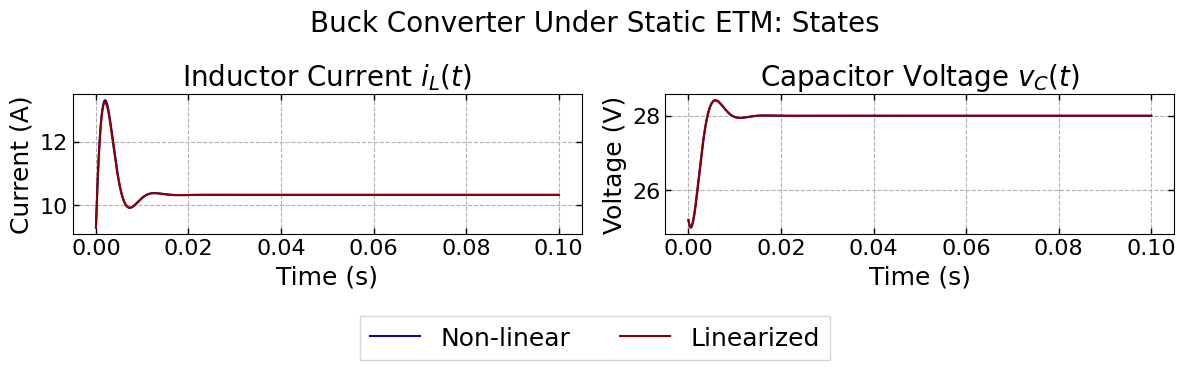

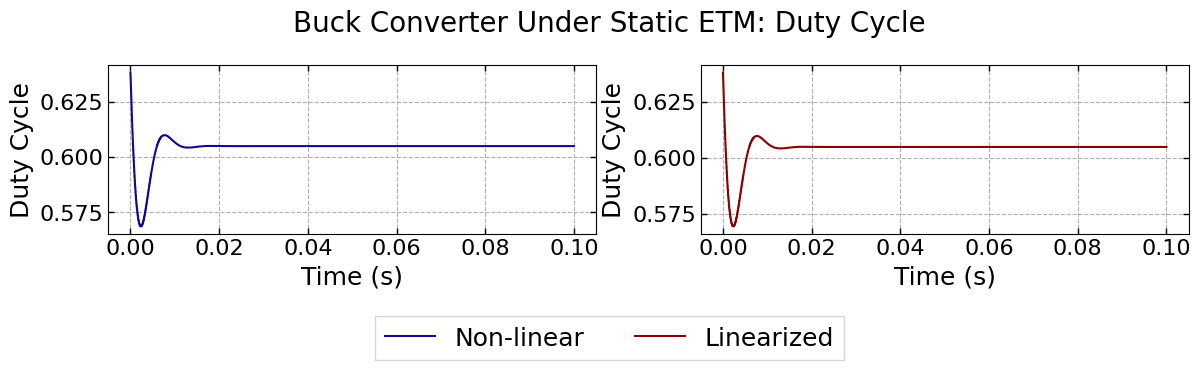

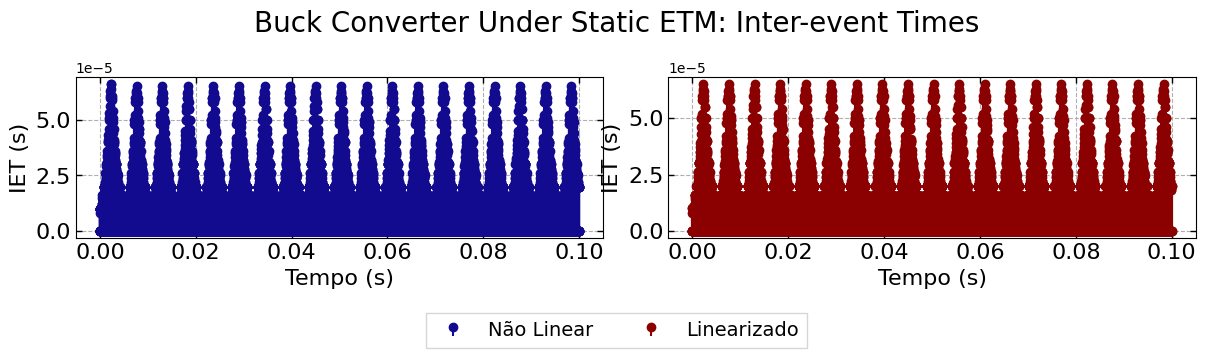

In [134]:
show_results("Buck Converter Under Static ETM",
             t_setm_nl, y_setm_nl, iet_setm_nl, et_setm_nl,
             t_setm_l, y_setm_l, iet_setm_l, et_setm_l)

#### 4.6.2 Closed-Loop Converter Simulation with Dynamic ETM

In [135]:
# Dynamic ETM (detm)
etm = DynamicETM('etm', Ψ, Ξ, θ=1, λ=100)

params = scenarios[SCENARIO_TAG]['params']

# Non-linear (nl) buck converter simulation
t_detm_nl, y_detm_nl, iet_detm_nl, et_detm_nl = closed_loop_simulate(
    shifted_nonlinear_sys, etm, params, scenarios[SCENARIO_TAG]['end_time'],
    x0_factor=scenarios[SCENARIO_TAG]['initial_states_factor'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],)

# Linearized (l) buck converter simulation
t_detm_l, y_detm_l, iet_detm_l, et_detm_l = closed_loop_simulate(
    linearized_buck_converter, etm, params, scenarios[SCENARIO_TAG]['end_time'],
    x0_factor=scenarios[SCENARIO_TAG]['initial_states_factor'],
    perturbation_signal_data=scenarios[SCENARIO_TAG]['perturbation_signal_data'],)

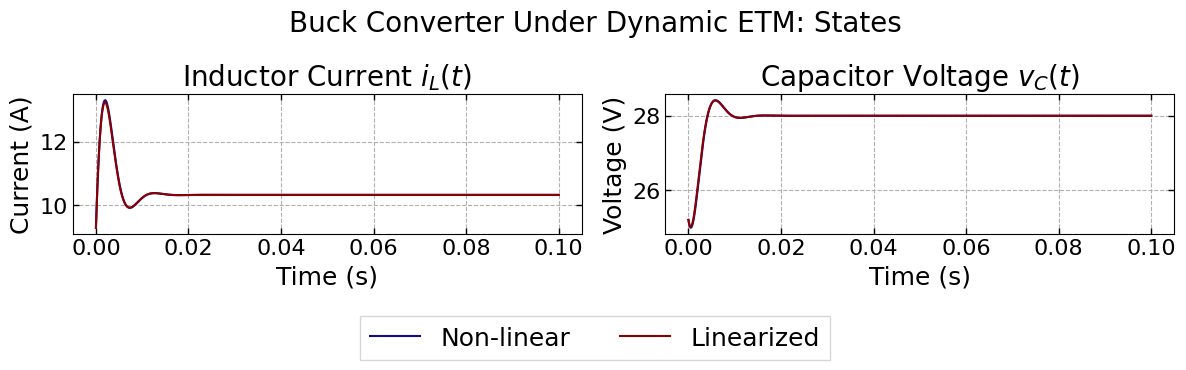

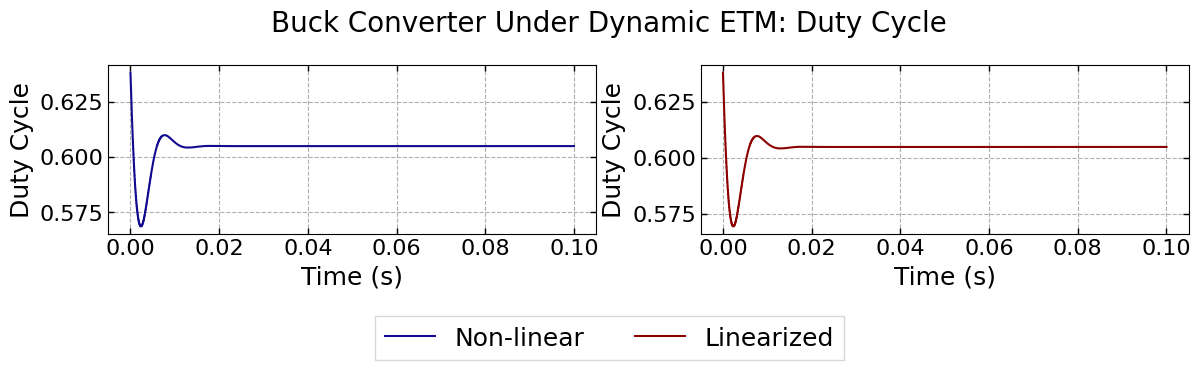

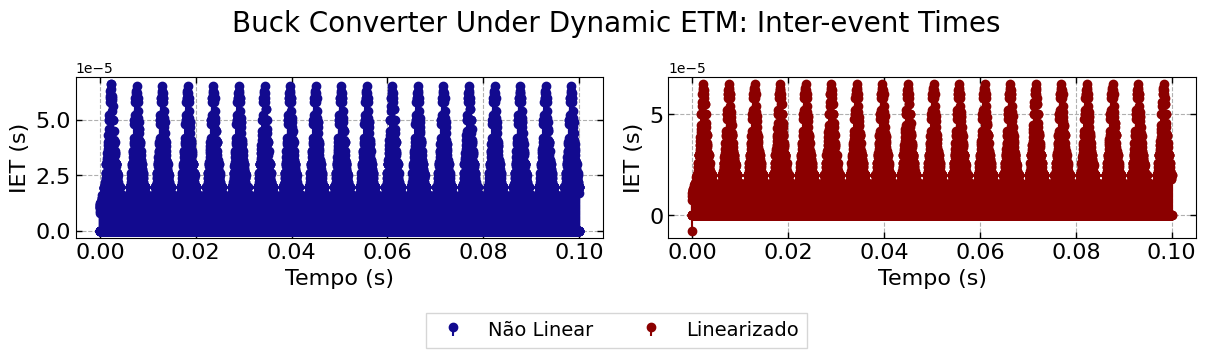

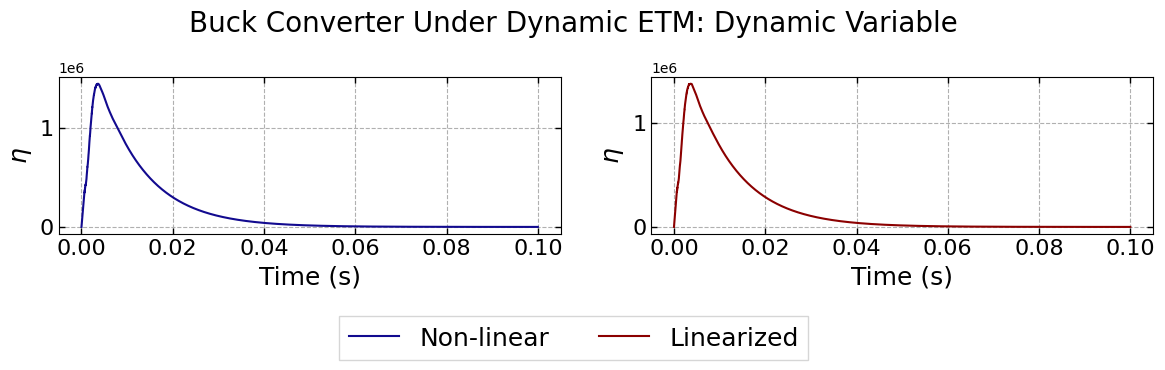

In [136]:
show_results("Buck Converter Under Dynamic ETM",
             t_detm_nl, y_detm_nl, iet_detm_nl, et_detm_nl,
             t_detm_l, y_detm_l, iet_detm_l, et_detm_l)